# Cohort Analysis<a id="Top"></a>

## Table of Contents

1. [Load Needed Packages](#1)<br>
2. [Get Data](#2)<br>
    2.1 [Read in the Data from URL](#2.1)<br>
    2.2 [Clean Data](#2.2)<br>
3. [Process Data](#3)<br>
4. [Cohort Results](#4)<br>
    4.1 [Retention Rate](#4.1)<br>
    4.2 [Average Order Value](#4.2)<br>

---
## 1. Load Needed Packages<a id=1></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from operator import attrgetter

import warnings
warnings.filterwarnings('ignore')

[Back to Top](#Top)

---
## 2. Get Data<a id=2></a>

### 2.1 Read in the Data from URL<a id=2.1></a>

In [2]:
# Load data from UCI Machine Learning Repository
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")
print('There are ' +str(len(df)) + ' observations')

There are 541909 observations


In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 2.2 Clean Data<a id=2.2></a>

In [4]:
# Check the structure or type of each variable
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Remove rows with null values
df.dropna(inplace=True)
print('There are ' +str(len(df)) + ' observations')

There are 406829 observations


In [6]:
# Drop duplicated values
df.drop_duplicates(inplace=True, ignore_index=True)
print('There are ' +str(len(df)) + ' observations')

There are 401604 observations


[Back to Top](#Top)

---
## 3. Process Data<a id=3></a>

In [7]:
# Add a new column containing only the Year and Month from the Invoice Date
df['InvoicePeriod'] = pd.to_datetime(df['InvoiceDate']).dt.to_period('M')

df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoicePeriod
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12


In [8]:
# Identify the cohort group for each customer (based on their first transaction)
df.set_index('CustomerID', inplace=True)
df['CohortGroup'] = df.groupby(level=0)['InvoiceDate'].min().dt.to_period('M')
df.reset_index(inplace=True)

df.head(2)

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,InvoicePeriod,CohortGroup
0,17850.0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,2010-12,2010-12
1,17850.0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,2010-12,2010-12


In [9]:
# Calculate the total amount by StockCode
df['InvoiceTotal'] = df['Quantity']*df['UnitPrice']

# Sum the total amount by InvoiceNo
df = df.groupby(['CustomerID','InvoiceNo','Country','InvoicePeriod','CohortGroup']).InvoiceTotal.sum().reset_index()

df.head(2)

,CustomerID,InvoiceNo,Country,InvoicePeriod,CohortGroup,InvoiceTotal
0,12346.0,541431,United Kingdom,2011-01,2011-01,77183.6
1,12346.0,C541433,United Kingdom,2011-01,2011-01,-77183.6


In [10]:
# Compute the period between the CohortGroup (First-Time Purchase) and the InvoicePeriod
df['CohortPeriod'] = (df.InvoicePeriod - df.CohortGroup).apply(attrgetter('n'))

In [11]:
# Group data by CohortGroup and InvoicePeriod
df_groupby = df.groupby(['CohortGroup', 'InvoicePeriod','CohortPeriod'])

# Count number of customers, transactions, and total charges
df_cohort = df_groupby.agg({'CustomerID': pd.Series.nunique,
                            'InvoiceNo': pd.Series.nunique,
                            'InvoiceTotal': np.mean})

# Rename columns
df_cohort.rename(columns={'CustomerID': 'TotalCustomers',
                          'InvoiceNo': 'TotalTransactions',
                          'InvoiceTotal': 'AOV'}, inplace=True)

df_cohort.head()

TotalCustomers  TotalTransactions  \
CohortGroup InvoicePeriod CohortPeriod                                      
2010-12     2010-12       0                        948               1708   
            2011-01       1                        362                689   
            2011-02       2                        317                579   
            2011-03       3                        367                753   
            2011-04       4                        341                611   

                                               AOV  
CohortGroup InvoicePeriod CohortPeriod              
2010-12     2010-12       0             323.403314  
            2011-01       1             393.441292  
            2011-02       2             397.955389  
            2011-03       3             400.769509  
            2011-04       4             328.241489

In [12]:
# Reindex the DataFrame
df_cohort.reset_index(inplace=True)
df_cohort.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

df_cohort.head(2)

InvoicePeriod  TotalCustomers  TotalTransactions  \
CohortGroup CohortPeriod                                                    
2010-12     0                  2010-12             948               1708   
            1                  2011-01             362                689   

                                 AOV  
CohortGroup CohortPeriod              
2010-12     0             323.403314  
            1             393.441292

[Back to Top](#Top)

---
## 4. Cohort Results<a id=4></a>

### 4.1 Retention Rate<a id=4.1></a>

In [13]:
# Turn dataframe to pivot table format
pivot_cohort = df_cohort['TotalCustomers'].unstack(0)

pivot_cohort.head(2)

CohortGroup,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
CohortPeriod,,,,,,,,,,,,,
0,948.0,421.0,380.0,440.0,299.0,279.0,235.0,191.0,167.0,298.0,352.0,321.0,41.0
1,362.0,101.0,94.0,84.0,68.0,66.0,49.0,40.0,42.0,89.0,93.0,43.0,NaN


In [14]:
# Divide dataframe by first row (total customers in CohortGroup) to get retention rate
cohort_retention = pivot_cohort.div(pivot_cohort.iloc[0], axis=1)

cohort_retention.head(2)

CohortGroup,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
CohortPeriod,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
1,0.381857,0.239905,0.247368,0.190909,0.227425,0.236559,0.208511,0.209424,0.251497,0.298658,0.264205,0.133956,NaN


In [15]:
# Transpose index and columns
cohort_retention = cohort_retention.T
cohort_retention

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortGroup,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-- Visualize Retention Rate --

<AxesSubplot:xlabel='CohortPeriod', ylabel='CohortGroup'>

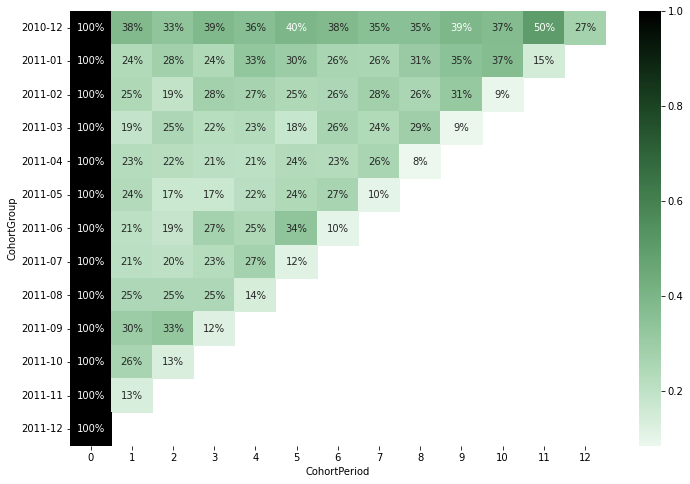

In [16]:
# Set size of figure
fig = plt.figure(figsize=(12,8))

# Creat mask
mask = cohort_retention.isnull()

# Generate a new colormap
# https://seaborn.pydata.org/tutorial/color_palettes.html
cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=False, as_cmap=True)
 
# Plot a triangle retention heatmap
sns.heatmap(cohort_retention, cmap=cmap, annot=True, fmt='.0%', mask=mask)

### 4.2 Average Order Value<a id=4.2></a>

In [17]:
# Cohort AOV per Month
cohort_aov = df_cohort['AOV'].unstack(0)
cohort_aov = cohort_aov.T
cohort_aov

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortGroup,,,,,,,,,,,,,
2010-12,323.403314,393.441292,397.955389,400.769509,328.241489,400.871286,424.456399,439.113488,469.164402,583.454398,578.196496,448.882132,461.703266
2011-01,370.476874,375.922819,341.503956,274.535497,352.742446,428.011888,394.294663,422.789419,392.966460,441.480681,430.656950,312.064270,NaN
2011-02,314.568354,184.960735,329.967611,282.523889,252.538652,231.463657,384.132258,339.525000,380.408676,323.124439,235.051750,NaN,NaN
2011-03,345.781734,214.342358,301.094663,268.310133,327.430141,311.397398,380.672579,380.156522,292.277748,232.195000,NaN,NaN,NaN
2011-04,309.745624,264.833028,267.704946,305.941026,312.596506,332.025056,298.518617,280.589833,196.059375,NaN,NaN,NaN,NaN
2011-05,315.558087,189.493441,294.353594,255.555571,284.755699,377.589195,276.639646,285.451892,NaN,NaN,NaN,NaN,NaN
2011-06,309.390470,190.882958,238.662414,328.228571,325.963291,306.158760,261.382667,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,279.721366,222.525400,260.167797,299.350351,225.878214,240.988000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,381.789507,323.615763,471.659143,586.336765,543.970385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-- Visualize AOV --

<AxesSubplot:xlabel='CohortPeriod', ylabel='CohortGroup'>

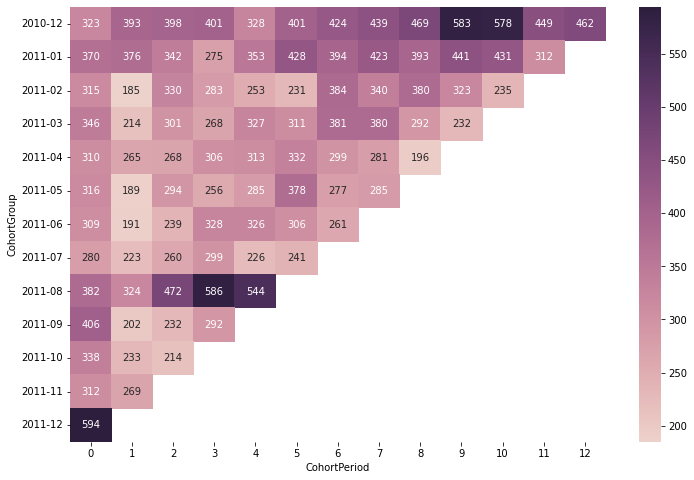

In [18]:
# Set size of figure
fig = plt.figure(figsize=(12,8))

# Creat mask
mask = cohort_aov.isnull()

# Generate a new colormap
# https://seaborn.pydata.org/tutorial/color_palettes.html
cmap = sns.cubehelix_palette(as_cmap=True)
 
# Plot a triangle aov heatmap
sns.heatmap(cohort_aov, cmap=cmap, annot=True, fmt='.0f', mask=mask)

[Back to Top](#Top)